# EX4 - CNNs & Transfer Learning


## 1. Convolutional Network on CIFAR dataset

#### 1.a. You should change the network to have convolutional layers. We do not guide you about the number of layers, number of filters and filter sizes.

We'll start with some imports and data preparation first

In [1]:
%matplotlib inline
import warnings
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

dataloaders = {
    "train": trainloader,
    "val": valloader
}

dataset_sizes = {
    "train": trainset.data.shape[0],
    "val": valset.data.shape[0]
}

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Training and evaluation functions:

In [11]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    training_results = {p: [] for p in ['train', 'val']}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_results[phase].append({'epoch': epoch, 'epoch_loss': epoch_loss, 'epoch_acc': epoch_acc})

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_results


def get_unified_stats_df(stats):
  train_stats_df = pd.DataFrame(stats['train'])
  train_stats_df['Dataset'] = 'train'
  train_stats_df.epoch_acc = train_stats_df.epoch_acc.apply(lambda x: x.cpu().detach().numpy())
  val_stats_df = pd.DataFrame(stats['val'])
  val_stats_df['Dataset'] = 'validation'
  val_stats_df.epoch_acc = val_stats_df.epoch_acc.apply(lambda x: x.cpu().detach().numpy())
  return pd.concat([train_stats_df, val_stats_df]).reset_index(drop=True)


def train_model_end2end(nn_obj, criterion, num_epochs, sgd_lr, sgd_momentum, sgd_nesterov):
  model = nn_obj.to(device)
  model = model.to(device)
  optimizer_ft = optim.SGD(model.parameters(), lr=sgd_lr, momentum=sgd_momentum)

  # Decay LR by a factor of 0.1 every 7 epochs - I did not change it as recommended in the above instructions
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  model, stats = train_model(model, 
                    dataloaders,
                    criterion, 
                    optimizer_ft, 
                    exp_lr_scheduler,
                    num_epochs=num_epochs)
  
  return model, stats

### Model Selection

#### a.1. Please give some explanations on the selection of the model. Have you tried other architecture? Different hyper-parameters? We would like to see the way you reached your final model.

##### Initial attempts

Initially we started with a very naive and simple network that did not work very well.

We started with 8 layers that duplicate the same convolutional layer, without any dropout / normalization / max pooling:


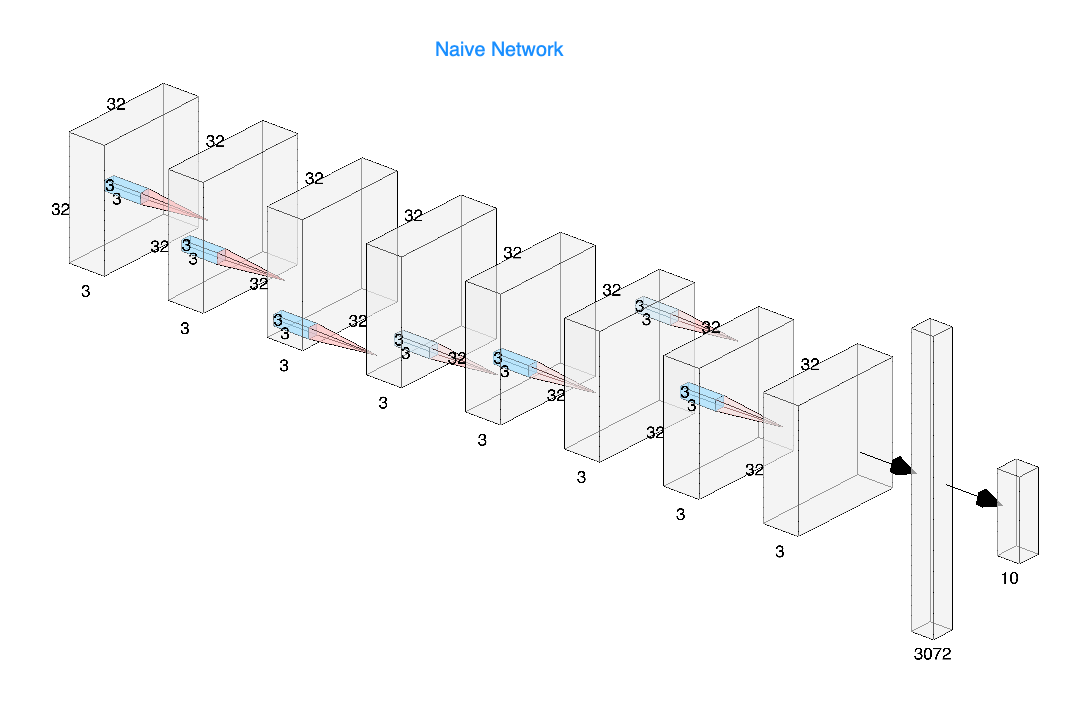

In [35]:
from IPython.display import Image
Image(filename='naive_network.png') 

Each layer had 3 filters with kernel of 3x3 with stride and padding of 1.



The results were poor, even worse than the network we created in the home assignment (less than 40% accuracy).


##### Intermidiate architectures
We then decided to improve the network with the different tools we've learned so far.

We did 3 things:
1. We increased the convolutional layers number of filters and kernel sizes.
We started by increasing the filter number to 8 per layer (following up our research seminar - we saw that increasing the number of filters to this size improved performance).
2. Adding batch normalization after every convolutional layer 
We did this in order to speed up training and to make our model more robust similarly to the way google did in inception V3 in 2016 (batch norm after each convolutional layer yielded the best results for them).
3. Adding max pooling after every two layers.
This one was inspired by the multiple network architectures we’ve seen in our lecture like VGG for example which uses max pooling after every 2 / 3 conv layers.



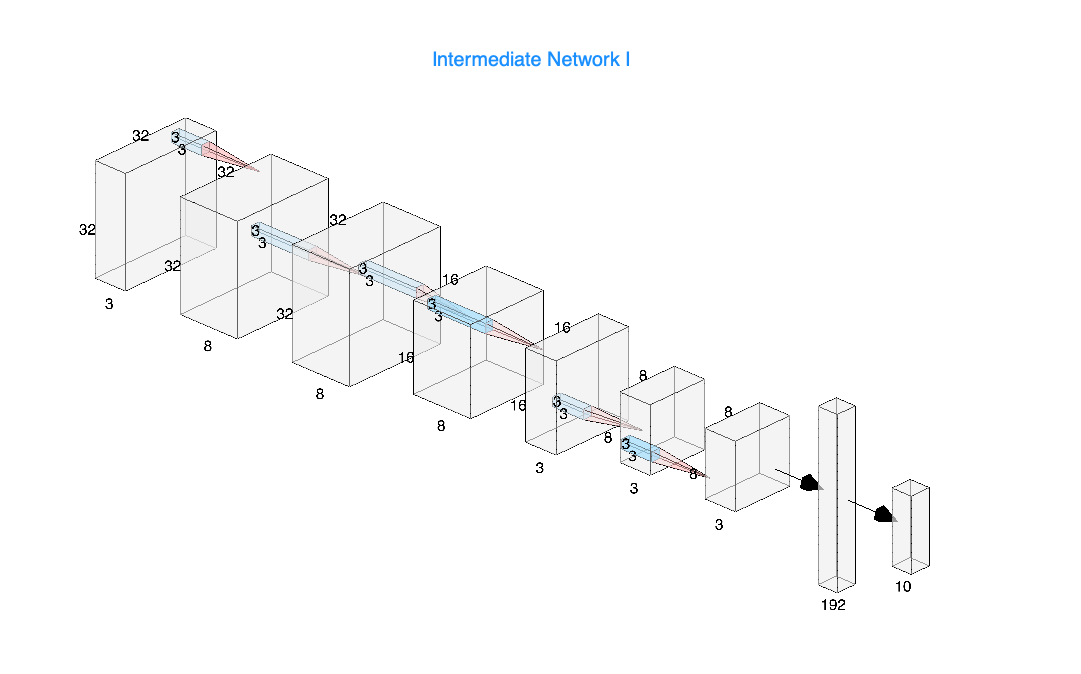

In [36]:
from IPython.display import Image
Image(filename='imn_1.png') 


This network yielded decent results that already surpassed our original network from task 2 (70% accuracy on the validation vs 58% in the previous task).

We still believed we have potential for greater improvement in the architecture before we move to tuning patameters, therefor we wanted to experiment with larger networks with additional convolutions and different filter sizes more similar to modern networks we already played with.


##### Final architecture - Part 1
After additional attempts we decided to increase the number of filters greatly and to increase the kernel size to 5 in the first layers similar to known networks like AlexNet / Resnet / got to the next network:


This network contains:
- Input images of 32x32 pixels, 3 color channels
- 2 base convolutional layers
  - Each layer contains 64 5x5 filters, stride of 1, padding of 2
  - Batch normalization
  - ReLu activation
- Max pooling with 2x2 kernel and stride of 2 (reduced to 64x16x16)
- 2 mid convolutional layers
  - Each layer contains 128 3x3 filters, stride of 1, padding of 1
  - Batch normalization
  - ReLu activation
- Max pooling with 2x2 kernel and stride of 2 (reduced to 128x8x8)
- 2 final convolutional layers
  - Each layer contains 256 3x3 filters, stride of 1, padding of 1
  - Batch normalization
  - ReLu activation
- FC of 16,512 input neurons (256*8*8=16,512) and 1024 outputs
- FC of 1,024 input neurons and 10 final outputs


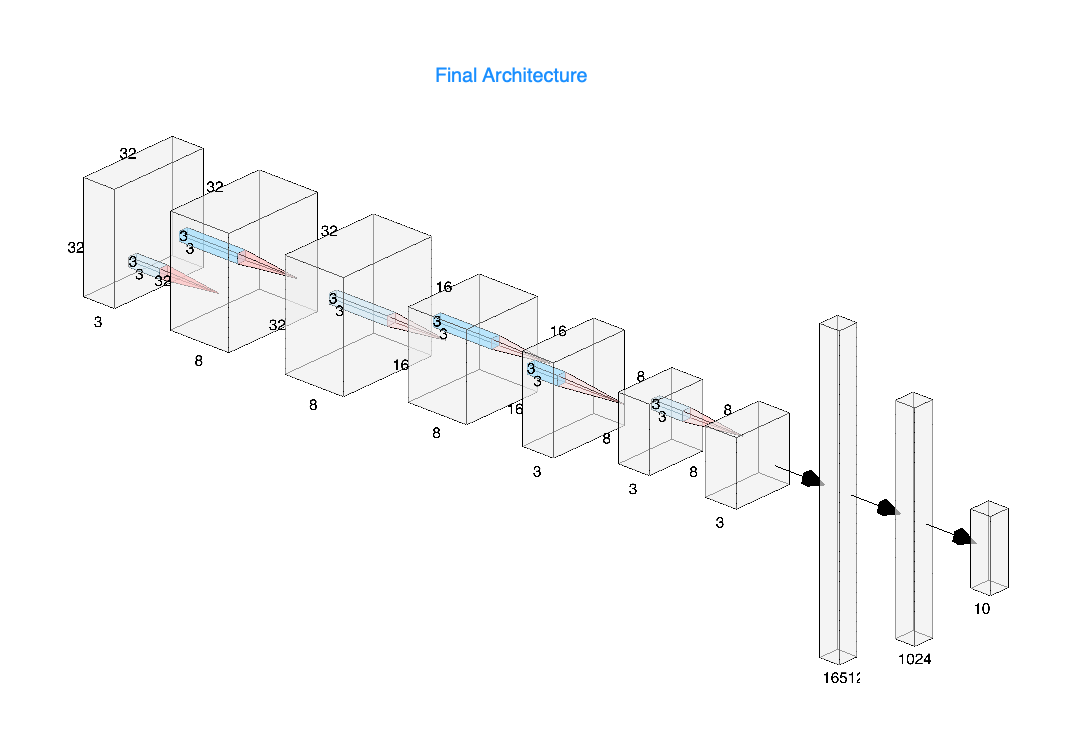

In [42]:
from IPython.display import Image
Image(filename='final_nn.png') 

This network really yielded the best results so far, after 15 epochs~ we got 0.9997 accuracy on the train set and 0.8547.



##### Final architecture - Part 2
This was a small red flag (of overfitting), due to this flag we decided we will add dropout to the last layers as you can see below, so the final architecture looked like:

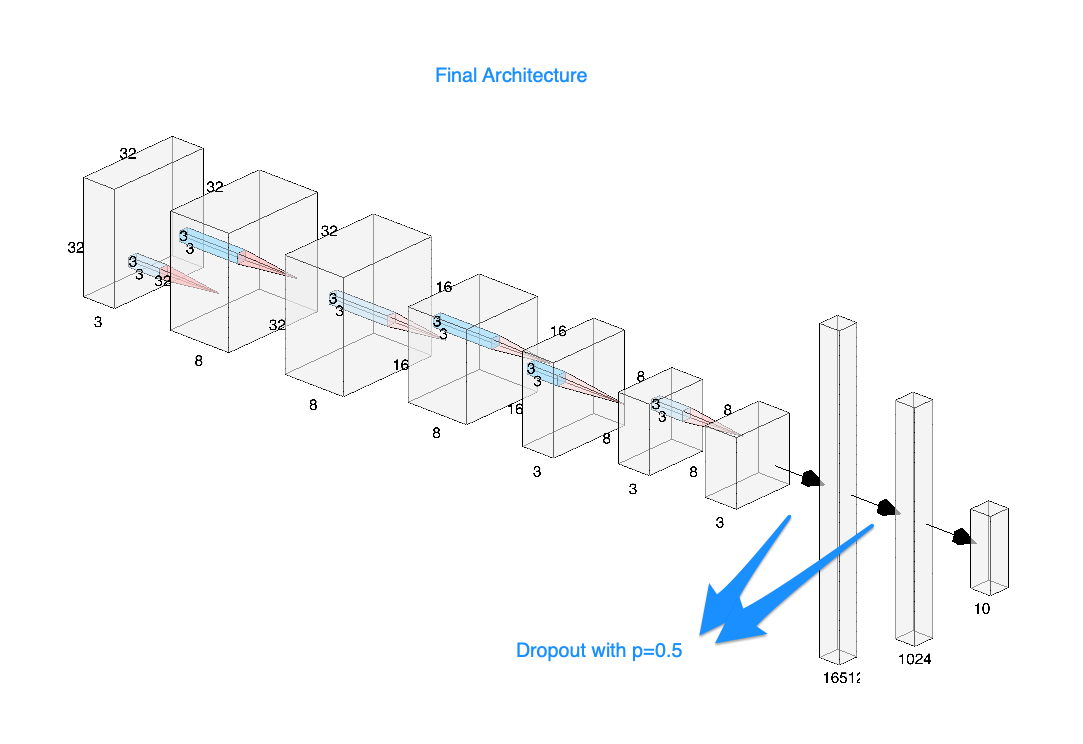

In [43]:
from IPython.display import Image
Image(filename='final_nn2.png') 


As we saw, this pretty much kept similar results (with slight improvement on the validation set of 1%) but the train set performance decreased, so the gap that indicated overfitting did decrease here as expected from dropout.

The reason we added the dropout where we did was that as we saw in multiple research papers and in the original paper that suggested the use of dropout, that dropout should be added between layers with the largest number of parameters and usually between dense layers (where they recommended for hidden units to use p=0.5 as it is usually very close to the optimal value).

Dropout refernces:
- https://arxiv.org/pdf/1207.0580.pdf
- https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf


We could ask why did we not continue to deeper network or more complicated networks that use resnet blocks / skip-connections / etc.
The reason was that we got to a place where 15 epochs took long enough so that our params optimizations will take hours so we decided to stick with this architecture at the moment.

#### Final architecture implementation and base training

In [23]:
class BaseNeuralNetwork(nn.Module):
    """
    Final network - Part 1 Network (without dropout)
    """
    def __init__(self):
        super(BaseNeuralNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.layer6 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()      
        )

        self.fc1 = nn.Sequential(
            nn.Linear(256 * 8 * 8, 1024),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(1024, 10),
            nn.ReLU()
        )



    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [24]:
model = BaseNeuralNetwork().to(device)
print(model)

BaseNeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer6): Seque

In [25]:
# !pip install torchsummary 
from torchsummary import summary
summary(model.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]         102,464
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
              ReLU-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,


The next two cells (defining the loss and the training loop) were copied from last exercise. 


In [ ]:
# If a GPU is available, make the model use it
model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [34]:
base_model_configurations = [
 {
    "config_name": "nn_base",
    "params": {"nn_obj": BaseNeuralNetwork(),
               "criterion": nn.CrossEntropyLoss(),
               "sgd_lr": 0.01,
               "sgd_momentum": 0.9,
               "sgd_nesterov": False,
               "num_epochs": 15} 
 }
]



base_results = []

for model_conf in base_model_configurations:
  conf_name = model_conf.get('config_name')
  params = model_conf.get('params')
  
  print(f"\n\nStarting to train model with conf name - {conf_name}")
  model, stats = train_model_end2end(**params)
  unified_stats_df = get_unified_stats_df(stats)

  base_results.append((conf_name, model, unified_stats_df))




Starting to train model with conf name - nn_base
Epoch 0/14
----------
train Loss: 1.2533 Acc: 0.5532
val Loss: 0.9652 Acc: 0.6647

Epoch 1/14
----------
train Loss: 0.7221 Acc: 0.7451
val Loss: 0.9263 Acc: 0.6988

Epoch 2/14
----------
train Loss: 0.5328 Acc: 0.8138
val Loss: 0.6755 Acc: 0.7731

Epoch 3/14
----------
train Loss: 0.3911 Acc: 0.8639
val Loss: 0.7437 Acc: 0.7670

Epoch 4/14
----------
train Loss: 0.2706 Acc: 0.9052
val Loss: 0.6621 Acc: 0.7964

Epoch 5/14
----------
train Loss: 0.1809 Acc: 0.9367
val Loss: 0.6357 Acc: 0.8078

Epoch 6/14
----------
train Loss: 0.1085 Acc: 0.9630
val Loss: 0.6514 Acc: 0.8221

Epoch 7/14
----------
train Loss: 0.0302 Acc: 0.9945
val Loss: 0.5495 Acc: 0.8520

Epoch 8/14
----------
train Loss: 0.0152 Acc: 0.9987
val Loss: 0.5680 Acc: 0.8524

Epoch 9/14
----------
train Loss: 0.0110 Acc: 0.9994
val Loss: 0.5787 Acc: 0.8551

Epoch 10/14
----------
train Loss: 0.0089 Acc: 0.9997
val Loss: 0.5918 Acc: 0.8547

Epoch 11/14
----------
train Loss: 

After playing with the above architecture, we see that we still have a rad flag that indicates **overfitting**:
- The train vs. validation accuracy has large gap (15%~)
- The train accuracy is almost perfect


Therfor we decided to try and handle this issue by adding 2 dropouts in the areas where the number of paramaters is the largest (between the last conv layer and the FC layer + between the 2 last FC layers).

In [45]:
class FinalNetwork(nn.Module):
    """
    The final network that we decided to optimize
    """
    def __init__(self):
        super(FinalNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.layer6 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()      
        )

        self.dropout1 = nn.Dropout(p=0.5)

        self.fc1 = nn.Sequential(
            nn.Linear(256 * 8 * 8, 1024),
            nn.ReLU()
        )

        self.dropout2 = nn.Dropout(p=0.5)

        self.fc2 = nn.Sequential(
            nn.Linear(1024, 10),
            nn.ReLU()
        )



    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        return out

In [47]:
base_model_configurations = [
 {
    "config_name": "nn_base_with_dropout",
    "params": {"nn_obj": FinalNetwork(),
               "criterion": nn.CrossEntropyLoss(),
               "sgd_lr": 0.01,
               "sgd_momentum": 0.9,
               "sgd_nesterov": False,
               "num_epochs": 15} 
 }
]

base_results = []

for model_conf in base_model_configurations:
  conf_name = model_conf.get('config_name')
  params = model_conf.get('params')
  
  print(f"\n\nStarting to train model with conf name - {conf_name}")
  model, stats = train_model_end2end(**params)
  unified_stats_df = get_unified_stats_df(stats)

  base_results.append((conf_name, model, unified_stats_df))




Starting to train model with conf name - nn_base_with_dropout
Epoch 0/14
----------
train Loss: 1.4203 Acc: 0.4983
val Loss: 1.2306 Acc: 0.5694

Epoch 1/14
----------
train Loss: 0.9332 Acc: 0.6724
val Loss: 1.0104 Acc: 0.6520

Epoch 2/14
----------
train Loss: 0.7573 Acc: 0.7382
val Loss: 0.7909 Acc: 0.7233

Epoch 3/14
----------
train Loss: 0.6401 Acc: 0.7796
val Loss: 0.6279 Acc: 0.7864

Epoch 4/14
----------
train Loss: 0.5489 Acc: 0.8101
val Loss: 0.7760 Acc: 0.7524

Epoch 5/14
----------
train Loss: 0.4812 Acc: 0.8350
val Loss: 0.6259 Acc: 0.7917

Epoch 6/14
----------
train Loss: 0.4226 Acc: 0.8544
val Loss: 0.5978 Acc: 0.8039

Epoch 7/14
----------
train Loss: 0.2645 Acc: 0.9082
val Loss: 0.4561 Acc: 0.8533

Epoch 8/14
----------
train Loss: 0.2210 Acc: 0.9232
val Loss: 0.4584 Acc: 0.8535

Epoch 9/14
----------
train Loss: 0.1974 Acc: 0.9315
val Loss: 0.4593 Acc: 0.8541

Epoch 10/14
----------
train Loss: 0.1823 Acc: 0.9365
val Loss: 0.4607 Acc: 0.8576

Epoch 11/14
----------

### Params optimization

I mainly tried to optimize the learning rate, momentum and whether to use nestrov / not.
Other params I could have optimized are the dropout rates, and maybe initializations / etc. but I thought that we already got to decent results and I wanted to play with these parameters specifically and see how they impact the results.

In [50]:
final_results = []

tested_lr_values = [
                    # 0.001, # Dropped after seeing results weren't too good to save time & collab resources
                    # 0.003, # Dropped after seeing results weren't too good to save time & collab resources
                    0.005,
                    0.01,
                    # 0.03,  - Dropped after seeing results weren't too good to save time & collab resources
                    # 0.05 - Dropped after seeing results weren't too good to save time & collab resources
]

tested_momentum_values = [
                          0.8, 
                          0.9, 
                          0.95
]


for lr in tested_lr_values:
  for momentum in tested_momentum_values:
    for nesterov in [True, False]:
      nest_str = "nesterov" if nesterov else ''
      
      conf_name = f"nn_final_lr_{lr}_mom_{momentum}_{nest_str}"
      params = {"nn_obj": FinalNetwork(),
                "criterion": nn.CrossEntropyLoss(),
                "sgd_lr": lr,
                "sgd_momentum": momentum,
                "sgd_nesterov": nesterov,
                "num_epochs": 15} 
      
      print(f"\n\nStarting to train model with conf name - {conf_name}")
      model, stats = train_model_end2end(**params)
      unified_stats_df = get_unified_stats_df(stats)

      final_results.append((conf_name, model, unified_stats_df))
      




Starting to train model with conf name - nn_final_lr_0.005_mom_0.8_nesterov
Epoch 0/14
----------
train Loss: 1.4035 Acc: 0.4889
val Loss: 1.0484 Acc: 0.6253

Epoch 1/14
----------
train Loss: 0.9212 Acc: 0.6721
val Loss: 0.8008 Acc: 0.7141

Epoch 2/14
----------
train Loss: 0.7346 Acc: 0.7396
val Loss: 0.7312 Acc: 0.7417

Epoch 3/14
----------
train Loss: 0.6222 Acc: 0.7819
val Loss: 0.6762 Acc: 0.7650

Epoch 4/14
----------
train Loss: 0.5365 Acc: 0.8111
val Loss: 0.6374 Acc: 0.7813

Epoch 5/14
----------
train Loss: 0.4692 Acc: 0.8347
val Loss: 0.8197 Acc: 0.7266

Epoch 6/14
----------
train Loss: 0.4057 Acc: 0.8570
val Loss: 0.6116 Acc: 0.7979

Epoch 7/14
----------
train Loss: 0.2648 Acc: 0.9104
val Loss: 0.5000 Acc: 0.8350

Epoch 8/14
----------
train Loss: 0.2327 Acc: 0.9206
val Loss: 0.4930 Acc: 0.8345

Epoch 9/14
----------
train Loss: 0.2113 Acc: 0.9295
val Loss: 0.4994 Acc: 0.8375

Epoch 10/14
----------
train Loss: 0.1969 Acc: 0.9332
val Loss: 0.5074 Acc: 0.8355

Epoch 11

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8ab2a88ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8ab2a88ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.1120 Acc: 0.9638
val Loss: 0.4771 Acc: 0.8578

Training complete in 6m 2s
Best val Acc: 0.857800


Starting to train model with conf name - nn_final_lr_0.005_mom_0.95_nesterov
Epoch 0/14
----------
train Loss: 1.4850 Acc: 0.4682
val Loss: 1.0896 Acc: 0.6043

Epoch 1/14
----------
train Loss: 0.9773 Acc: 0.6583
val Loss: 0.8761 Acc: 0.6950

Epoch 2/14
----------
train Loss: 0.7823 Acc: 0.7292
val Loss: 0.8704 Acc: 0.7003

Epoch 3/14
----------
train Loss: 0.6728 Acc: 0.7694
val Loss: 0.6449 Acc: 0.7826

Epoch 4/14
----------
train Loss: 0.5830 Acc: 0.7980
val Loss: 0.6643 Acc: 0.7768

Epoch 5/14
----------
train Loss: 0.4999 Acc: 0.8293
val Loss: 0.5928 Acc: 0.7943

Epoch 6/14
----------
train Loss: 0.4411 Acc: 0.8472
val Loss: 0.5681 Acc: 0.8083

Epoch 7/14
----------
train Loss: 0.2936 Acc: 0.8994
val Loss: 0.4716 Acc: 0.8489

Epoch 8/14
----------
train Loss: 0.2441 Acc: 0.9153
val Loss: 0.4671 Acc: 0.8527

Epoch 9/14
----------
train Loss: 0.2202 Acc: 0.9237
val Loss: 

In [51]:
best_iters = []

for mname, _, stats_df in final_results:
  best_acc = stats_df[stats_df.Dataset == 'validation'].epoch_acc.max()
  print(f"Model: {mname} Validation best iteration acc: {best_acc}")
  best_iters.append({"model_name": mname, "best_accuracy": best_acc})

best_iters_df = pd.DataFrame(best_iters)
top_3_models = best_iters_df.sort_values('best_accuracy', ascending=False).head(3).model_name.tolist()

Model: nn_final_lr_0.005_mom_0.8_nesterov Validation best iteration acc: 0.8384
Model: nn_final_lr_0.005_mom_0.8_ Validation best iteration acc: 0.8415
Model: nn_final_lr_0.005_mom_0.9_nesterov Validation best iteration acc: 0.8559
Model: nn_final_lr_0.005_mom_0.9_ Validation best iteration acc: 0.8578
Model: nn_final_lr_0.005_mom_0.95_nesterov Validation best iteration acc: 0.8599
Model: nn_final_lr_0.005_mom_0.95_ Validation best iteration acc: 0.8560000000000001
Model: nn_final_lr_0.01_mom_0.8_nesterov Validation best iteration acc: 0.8514
Model: nn_final_lr_0.01_mom_0.8_ Validation best iteration acc: 0.8568
Model: nn_final_lr_0.01_mom_0.9_nesterov Validation best iteration acc: 0.8603000000000001
Model: nn_final_lr_0.01_mom_0.9_ Validation best iteration acc: 0.8654000000000001
Model: nn_final_lr_0.01_mom_0.95_nesterov Validation best iteration acc: 0.8551000000000001
Model: nn_final_lr_0.01_mom_0.95_ Validation best iteration acc: 0.8528


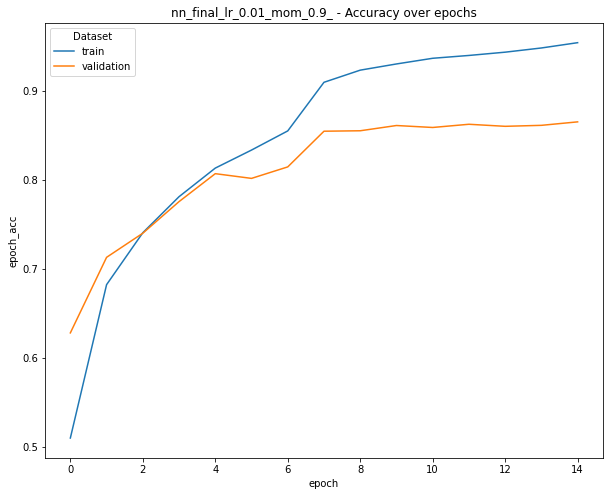

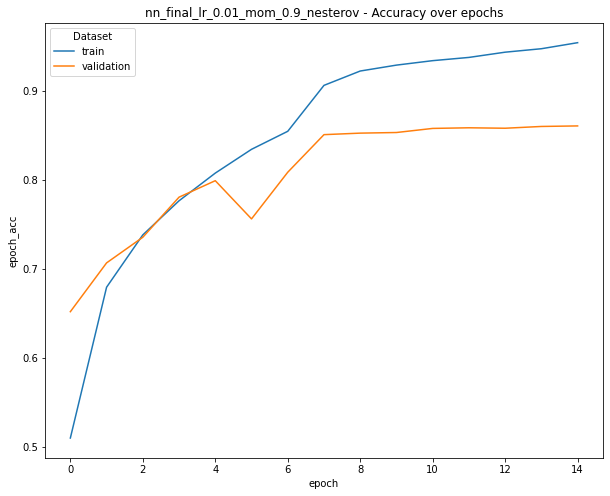

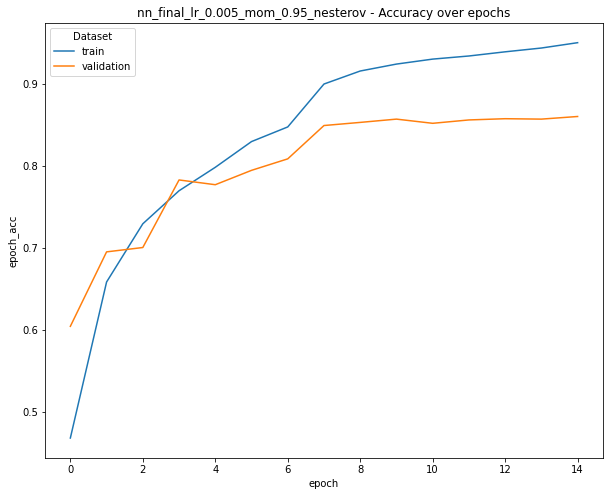

In [52]:
for model in top_3_models:
  mname, m, mdf = [i for i in final_results if i[0] == model][0]
  plt.figure(figsize=(10,8))
  sns.lineplot(data=mdf, hue='Dataset', x='epoch', y='epoch_acc').set(title=f"{mname} - Accuracy over epochs")
  plt.show()
  print()



#### 1.b. Why did you get better or worse accuracy when you use convolutional layers?
- Let's start with the results
  - In the previous task (ex 2), we got to a network with 0.58~ accuracy on the validation set
  - In the current task with convolutional networks we got to 0.8654 accuracy on the validation set

I would saw that there are many reasons for the improvement, some of the key points are:
1. Our understanding and the topics we've learned in the time between the excercises really helped here, from methods like dropout, batch normalization, max pooling, and such tools that can help optimize our CNNs that we were not aware of earlier.
2. We created a deeper network, in the original excercise we only had 2 FC hidden layers, now we have 6~ convolutional layers with a lof of filters per layer and 2 FC hidden layers, this means that we have a larger number of parameters by far that our model can optimize.
3. In general, convolutions are not fully connected, not all input nodes affect all output nodes. This gives convolutional layers more flexibility in learning specific features that can help the fully connected layers down the road.


### b. Add batch normalization layers to your network. Report your results.

As we already added batch normalization to the final architecture of the network that we chose to optimize, we elaborated that the premature networks we created without the batch normalization + max pooling yielded poor results (below 40% accuracy).

In the iteration that we chose to add batch norm + max pooling the performance raised almost to 70% accuracy on the validation set (as we also mentioned in our research seminar and above).

## 2. Transfer Learning

Ex1 - in ex1, you classified politicians using pre-defined networks. 

Specifically, we loaded the weights of a model that was trained on a different dataset. We talked in class that this procedure is called “transfer learning”. We also saw that we can fix the weights of the pe-trained networks.

In this exercise, you should explore four different configurations when using vgg-16 network:
1. Training the network with the pre-trained weights and fixating all the weights up to the
last layer (this is like we apply a classifier on a feature vector)
2. Training the network with the pre-trained weights and fixing the weights up the X layer
(you decide what is X).
3. Training the network from scratch (just use the architecture without the weights)
4. Training the network with the pre-trained weights without fixating (this is what was done
in ex1).


(a) Implement configurations 1-3.

(b) In what configuration did you get the best accuracy? Please also provide an explanation on why this is the best option and why the rest give worse performance.

### (a) Implement configurations 1-3.

We will start with code & dataset import from excercise #1 before the implementation:

In [2]:
## Imports

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from zipfile import ZipFile
plt.ion()   # interactive mode

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

In [19]:
# Loading the dataset (after we cleaned in in ex 1)

# with ZipFile('./data/israeli_politicians_v2.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
  #  zipObj.extractall(path='./data/israeli_politicians_v2/')



def generate_dataloaders():
  # Define transformations that resize the images to 256x256, and normalize them. 
  # The means and standard deviations of each channel are the values used for normalization in ImageNet
  means = [0.485, 0.456, 0.406]
  stds = [0.229, 0.224, 0.225]

  data_transforms = {
      'train': transforms.Compose([
          transforms.Resize((256, 256)),
          transforms.ToTensor(),
          transforms.Normalize(means, stds)
      ]),
      'val': transforms.Compose([
          transforms.Resize((256, 256)),
          transforms.ToTensor(),
          transforms.Normalize(means, stds)
      ]),
  }

  data_dir = r'./data/israeli_politicians_v2/'

  # Create a dictionary of train and val datasets from images in folders
  image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                            data_transforms[x])
                    for x in ['train', 'val']}

  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
  print('dataset_sizes: ', dataset_sizes)

  class_names = image_datasets['train'].classes
  print('class_names:', class_names)


  dataloaders = {
      'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=16,
                                              shuffle=True, num_workers=4),
      'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=16,
                                            shuffle=False, num_workers=4)
    }

  # Check for the availability of a GPU, and use CPU otherwise
  # If you are using Google Colab, be sure to change your runtime environment to GPU first.

  return dataloaders, dataset_sizes

In [20]:
# Training code

def train_modelv2(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    dataloaders, dataset_sizes = generate_dataloaders()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    training_results = {p: [] for p in ['train', 'val']}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_results[phase].append({'epoch': epoch, 'epoch_loss': epoch_loss, 'epoch_acc': epoch_acc})

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc


In [23]:
# Create function to train transfer networks for our problems based on configurable params

def train_transfer_end2end(vgg_pretrained, criterion, fixating_indicator=False, fixating_layers=4, num_epochs=10, sgd_lr=0.001, sgd_momentum=0.9):

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = init_vgg16(pretrained=vgg_pretrained)
  model = model.to(device)
  optimizer_ft = optim.SGD(model.parameters(), lr=sgd_lr, momentum=sgd_momentum)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  # Based on fixating indicator we decide whether or not to freeze the X first layers
  if fixating_indicator:
    fixed_counter = 0
    for child in model.features.children():
      fixed_counter += 1
      if fixed_counter <= fixating_layers:
        for param in child.parameters():
            param.requires_grad = False

    for child in model.classifier.children():
      fixed_counter += 1
      if fixed_counter <= fixating_layers:
        for param in child.parameters():
            param.requires_grad = False
    

  # Training itself
  out_model, best_acc = train_modelv2(model,
                    criterion, 
                    optimizer_ft, 
                    exp_lr_scheduler,
                    num_epochs=num_epochs)
  
  del out_model

  return best_acc


def init_vgg16(pretrained, out_features=9):
  # We load the model pretrained or just the architecture based on the pretrained param value.
  model = models.vgg16(pretrained=pretrained)
  model.classifier[6] = nn.Linear(in_features=4096, out_features=out_features)
  return model

In [24]:
base_model_configurations = [
 {
    "config_name": "conf_1_pretrained_fixating_all",
    "params": {"vgg_pretrained": True,
               "criterion": nn.CrossEntropyLoss(),
               "fixating_indicator": True,
               "fixating_layers": 37} 
 },
  {
    "config_name": "conf_2_pretrained_fixating_11_first", # I decided to fix weights up to 11th layer (includes the first 5 convolutional layers)
    "params": {"vgg_pretrained": True,
               "criterion": nn.CrossEntropyLoss(),
               "fixating_indicator": True,
               "fixating_layers": 11} 
 },
 {
    "config_name": "conf_3_untrained_unfixed",
    "params": {"vgg_pretrained": False,
               "criterion": nn.CrossEntropyLoss(),
               "fixating_indicator": False} 
 },
   {
    "config_name": "conf_4_pretrained_unfixed",
    "params": {"vgg_pretrained": True,
               "criterion": nn.CrossEntropyLoss(),
               "fixating_indicator": False} 
 },
]

base_results = []

for model_conf in base_model_configurations:
  conf_name = model_conf.get('config_name')
  params = model_conf.get('params')
  
  print(f"\n\nStarting to train model with conf name - {conf_name}")
  best_acc = train_transfer_end2end(**params)
  base_results.append((conf_name, best_acc))



Starting to train model with conf name - conf_1_pretrained_fixating_all
dataset_sizes:  {'train': 696, 'val': 167}
class_names: ['ayelet_shaked', 'benjamin_netanyahu', 'benny_gantz', 'danny_danon', 'gideon_saar', 'kostya_kilimnik', 'naftali_bennett', 'ofir_akunis', 'yair_lapid']
Epoch 0/9
----------
train Loss: 1.8567 Acc: 0.3290
val Loss: 1.5830 Acc: 0.4671

Epoch 1/9
----------
train Loss: 1.4618 Acc: 0.4856
val Loss: 1.4033 Acc: 0.5030

Epoch 2/9
----------
train Loss: 1.2650 Acc: 0.5704
val Loss: 1.3026 Acc: 0.5210

Epoch 3/9
----------
train Loss: 1.1241 Acc: 0.6121
val Loss: 1.2860 Acc: 0.5928

Epoch 4/9
----------
train Loss: 1.0861 Acc: 0.6351
val Loss: 1.2147 Acc: 0.5689

Epoch 5/9
----------
train Loss: 1.0082 Acc: 0.6566
val Loss: 1.2480 Acc: 0.5569

Epoch 6/9
----------
train Loss: 0.9763 Acc: 0.6609
val Loss: 1.1580 Acc: 0.6347

Epoch 7/9
----------
train Loss: 0.9016 Acc: 0.6983
val Loss: 1.1470 Acc: 0.5988

Epoch 8/9
----------
train Loss: 0.8788 Acc: 0.7126
val Loss: 

### (b) In what configuration did you get the best accuracy? Please also provide an explanation on why this is the best option and why the rest give worse performance.


### **Best configuration - (4)**

**(1) VGG-16 pretrained without fixating:**

Best Accuracy -  0.820359

Why?

This setup yields the best of both worlds, compared to other setups we had, getting the weights learned by VGG-16 to help generalization + fine-tuning all the weights, best as possible on a small dataset in the nubmer of epochs we've defined.

In addition, this was also supported by the experiments performed in the article we presented in the research seminar (https://arxiv.org/pdf/1411.1792.pdf) so when we take a large network and train it when we let all the layers to "fine-tune" on new data - we get the best results.


### **Other configurations -**

**(1) VGG-16 fixating all the weights up to the last layer:**

Best Accuracy - 0.634731

This one was also expected by us to have lower performance, as we learned higher layers tend to contain task specific features, VGG-16 is trained on a large dataset with a lot of classes, I believe that none of them are our Israeli politicians :) therefor, it was kind of expected that this setup won't work well.

This was also expected since we've seen it happen in the paper we had to present in the research seminar (https://arxiv.org/pdf/1411.1792.pdf) where AxB transfer model was trained when freezing all the 7 first layers, it had the worst performance in their experiment.

**(2) Training VGG-16(pretrained) with fixed 11 first layers:**

Best Accuracy - 0.802395

This one is slightly less better then configuration #4 since we don't let 11 of our layers to be fine-tuned to our data, I would expected a greater reduction in performance but potentially the network is deep enough and had enough parameters to tune and generalization methods in order to overcome the problem of the fixed weights (or maybe 11 layers still counts as we fixated only low level layers - only 5 conv layers are in the ones we "froze" - out of 16~ potential layers to fixate).


**(3) Training VGG-16 from scratch(not pretrained):**

Best Accuracy - 0.305389

This one was expected by us to have lower performance, as VGG-16 is trained ona huge dataset, for a lot of epochs, we expect the weights it learns improve generalization.
Our dataset is rather small so starting to train VGG-16 from scratch on it and optimizing the params for best results can take long time, and even then due to low number of samples (300~) I would expect overfitting and not generalization too much.
